In [3]:
import pdfplumber
from pdfminer.high_level import extract_pages
import IPython.display as display
from pymongo import MongoClient
from PIL import  ImageFont
from bson.objectid import ObjectId



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [33]:
TRIBUNAL = 'tjmg'
SPLIT = 'test'

In [34]:
labeled_corpus = MongoClient().juridico[TRIBUNAL+'_labeled_lines']
corpus = MongoClient().juridico[TRIBUNAL+'_crawler']

filter = {'$match' : {'dataset':SPLIT}}
#filter = {'$match' : {"process_id" : ObjectId("6220e3c428bdbbb7068626e5")}}

doc = labeled_corpus.find_one({'dataset':SPLIT},{'document.lines.tokens':0})
pdf_file = corpus.find_one({"_id": doc['process_id']},{'pdf_file':1})['pdf_file']



In [35]:
from collections import Counter
import hashlib


# gera uma lista de cores RGB
COLORS = []
vals = [0, 255, 127, 63, 191]
for v1 in vals:
    for v2 in vals:
        for v3 in vals:
            if v1 == v2 == v3:
                continue
            COLORS.append((v1, v2, v3, 50))


def get_color(map_string):
    return COLORS[int(hashlib.sha1(map_string.encode("utf-8")).hexdigest(), 16) % (10 ** 8)%len(COLORS)]

In [36]:
def process_page(pdf_page,resolution=300):
    im = pdf_page.to_image(resolution=resolution)
    rects = [{'rectangle':tuple(v for v in (e['x'], e['y']+e['height'], e['x']+e['width'], e['y'])),'section_label': e['section_label']} for e in doc['document'][pdf_page.page_number-1]['lines']]

    rect = (10,10,20,20)
    for section_label in (Counter([item['section_label'] for item in rects])):
        if section_label == 'None':continue
        color = get_color(section_label)
        im.draw_rect(rect,fill = color,stroke_width=0)
        font = ImageFont.truetype('/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf',resolution//6)
        im.draw.text((resolution/3, (rect[1]*(resolution/75))),section_label,(0,0,0),font=font)
        rect = (10,rect[1]+15,20,rect[3]+15)

    for rect in rects:
        if rect['section_label'] == 'None':continue
        color = get_color(rect['section_label'])
        im.draw_rect(rect['rectangle'],fill = color, stroke_width=0)

    ima = im.annotated
    pdf_pages_annotated.append(ima)    

In [37]:
pdf_pages_annotated = []
with pdfplumber.open(pdf_file) as pdf:
    for page in pdf.pages:
        process_page(page, 90)    

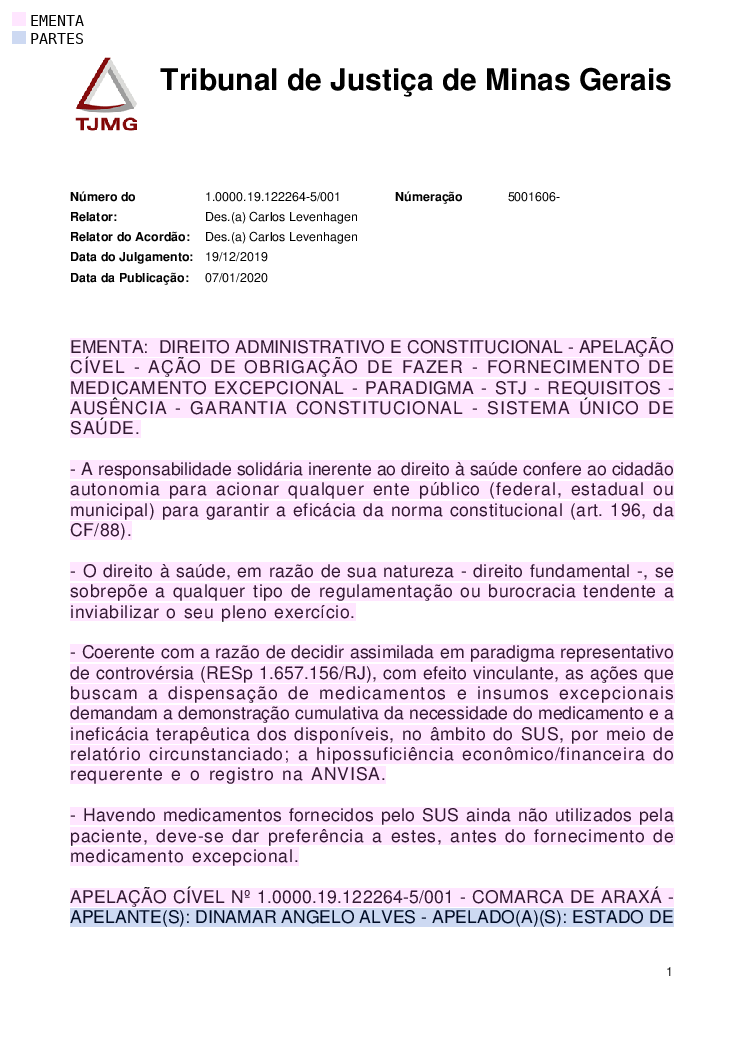

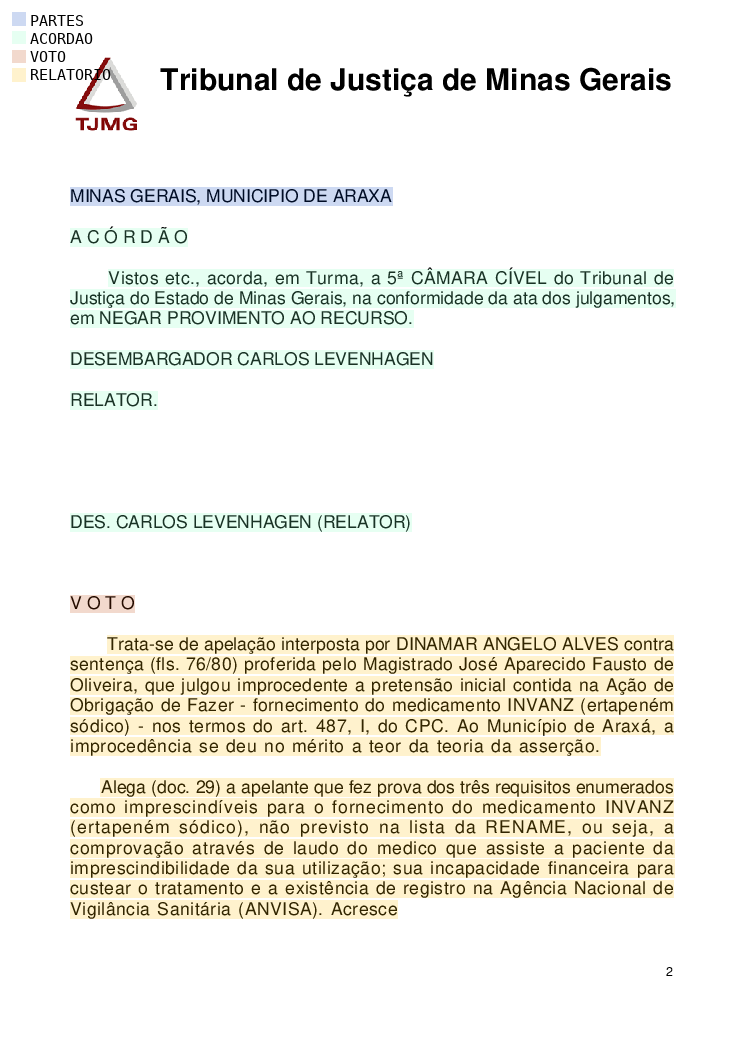

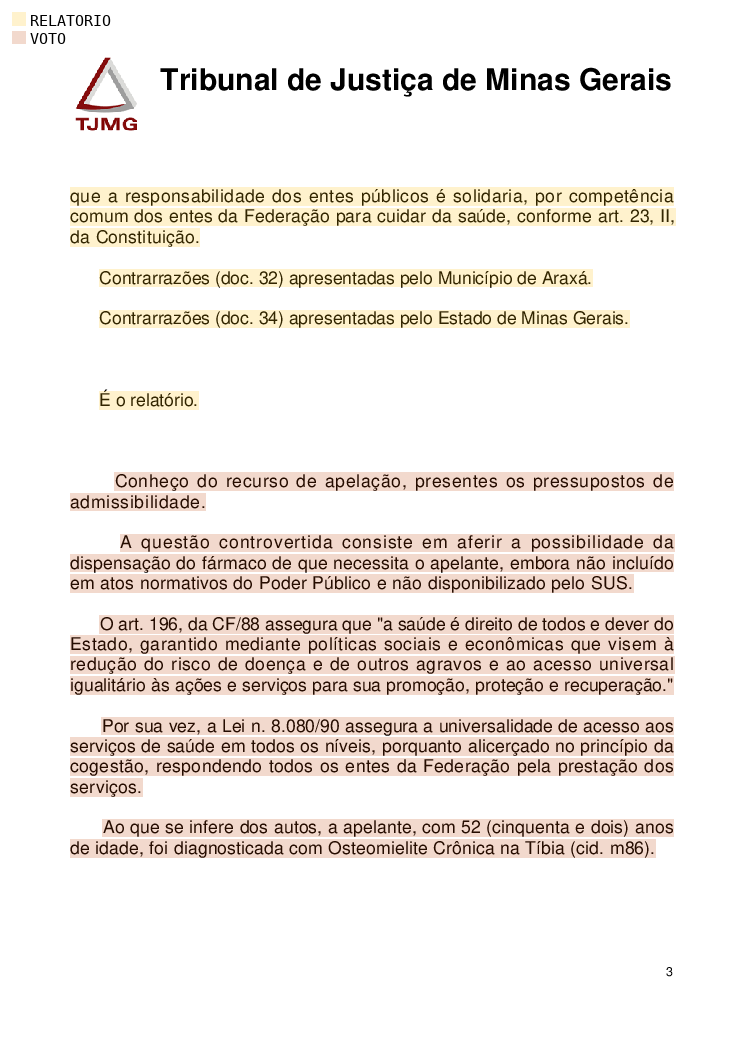

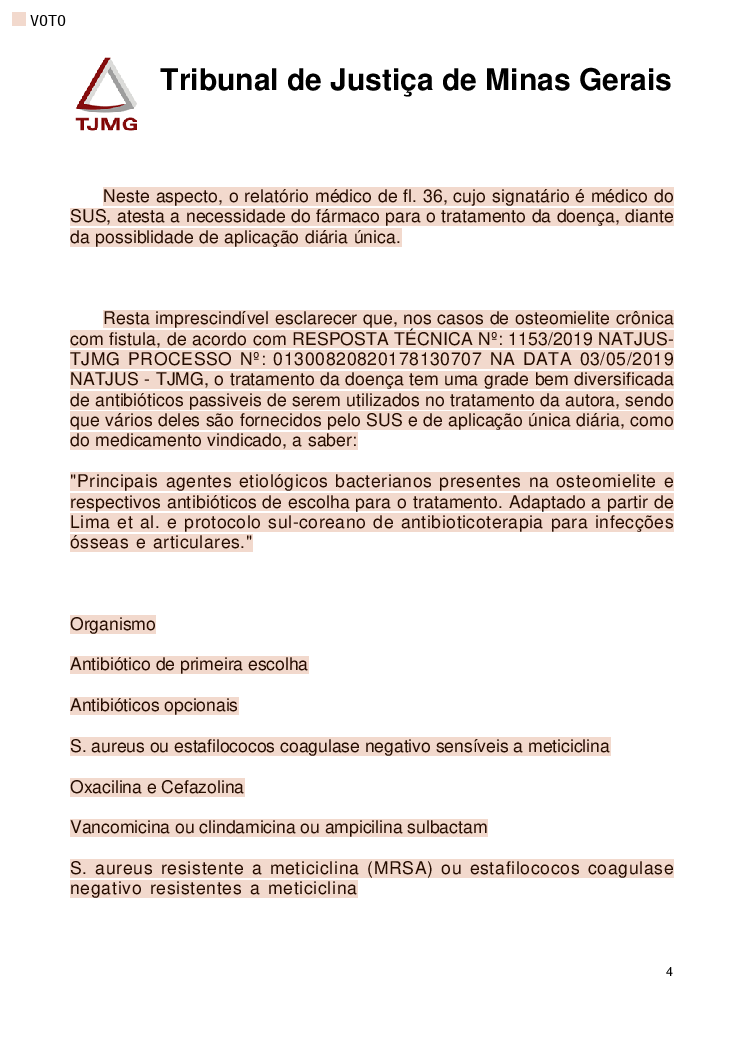

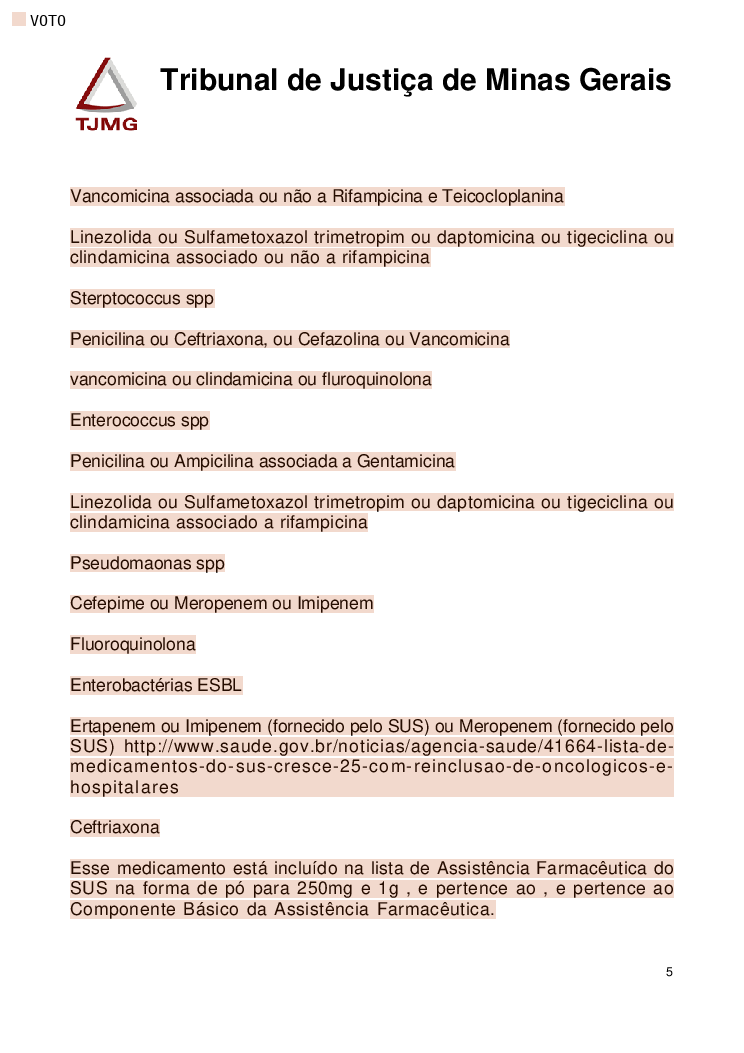

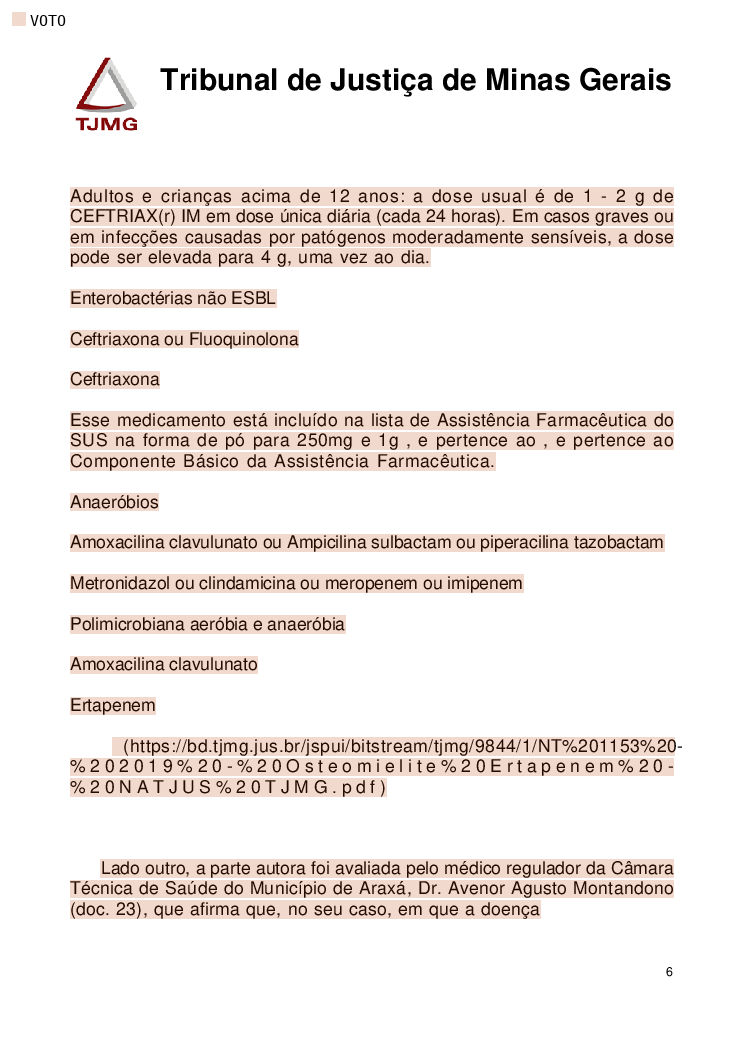

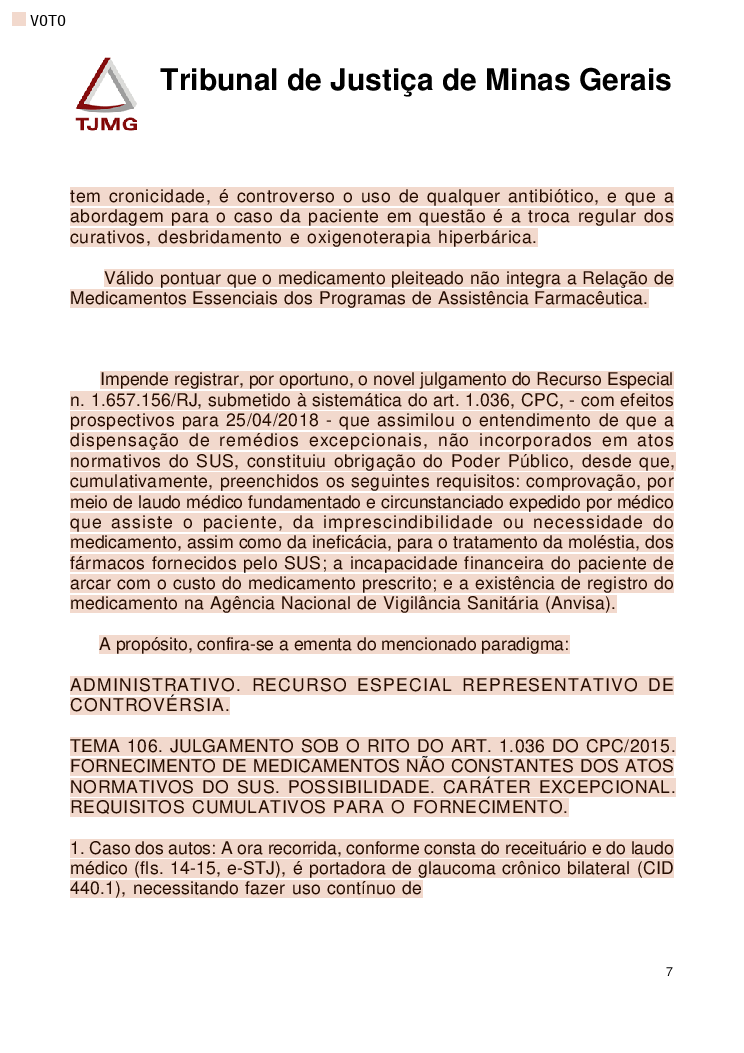

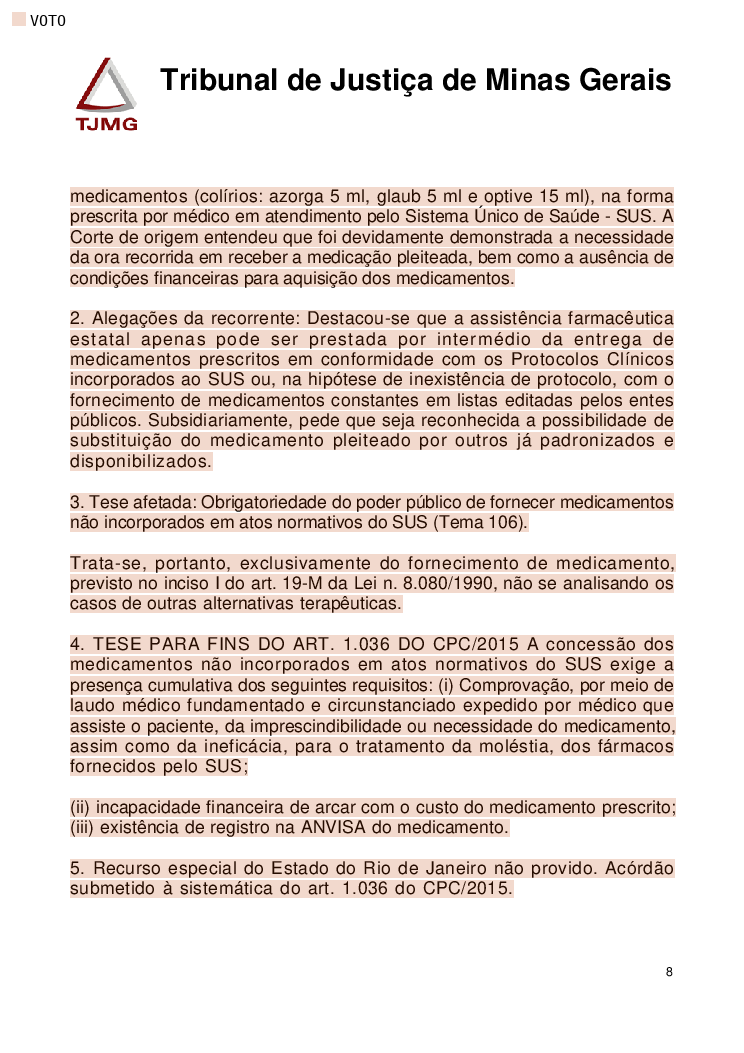

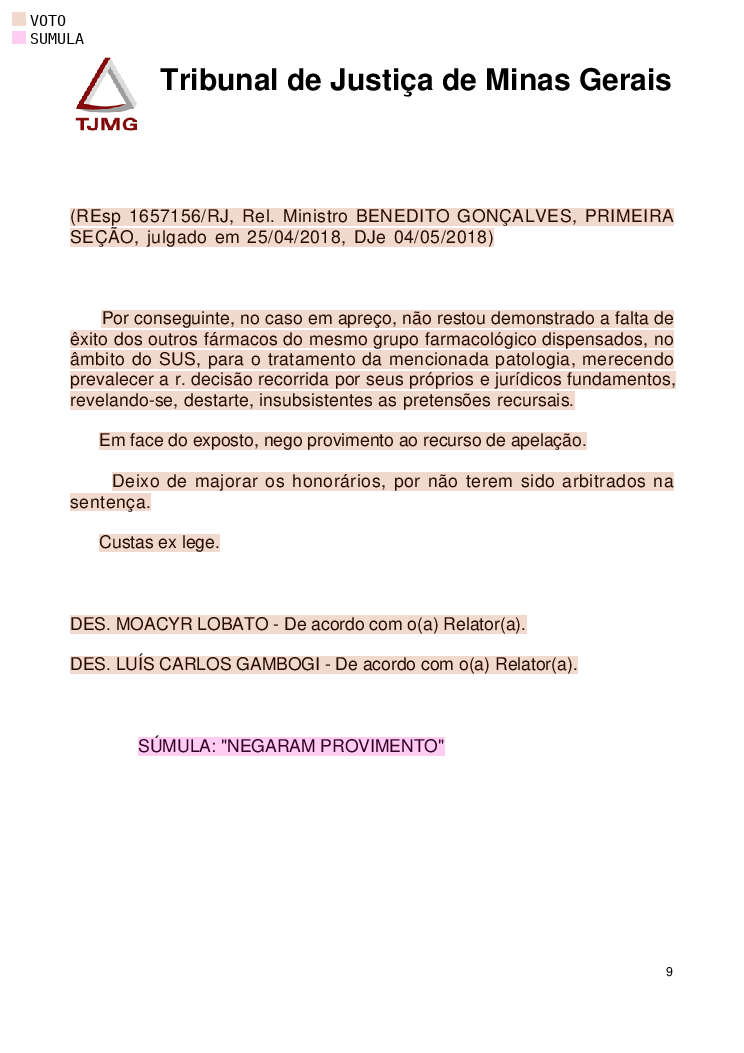

In [38]:
for img in pdf_pages_annotated:
    display.display(img)